In [7]:
# from google.colab import drive
# drive.mount('/content/drive')

In [8]:
!pip install seaborn

In [9]:
! pip install shap

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
                            roc_auc_score, precision_recall_curve, auc)
from imblearn.over_sampling import SMOTE
from scipy.stats import randint, uniform

In [11]:
df = pd.read_csv("/content/customer_booking.csv", encoding="ISO-8859-1")
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

In [13]:
print("Dataset Shape:", df.shape)
print("\nMissing Values:\n", df.isnull().sum())

Dataset Shape: (50000, 14)

Missing Values:
 num_passengers           0
sales_channel            0
trip_type                0
purchase_lead            0
length_of_stay           0
flight_hour              0
flight_day               0
route                    0
booking_origin           0
wants_extra_baggage      0
wants_preferred_seat     0
wants_in_flight_meals    0
flight_duration          0
booking_complete         0
dtype: int64


Overall booking completion rate: 14.96%


<ipython-input-14-098b1d507667>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='booking_complete', palette='viridis')


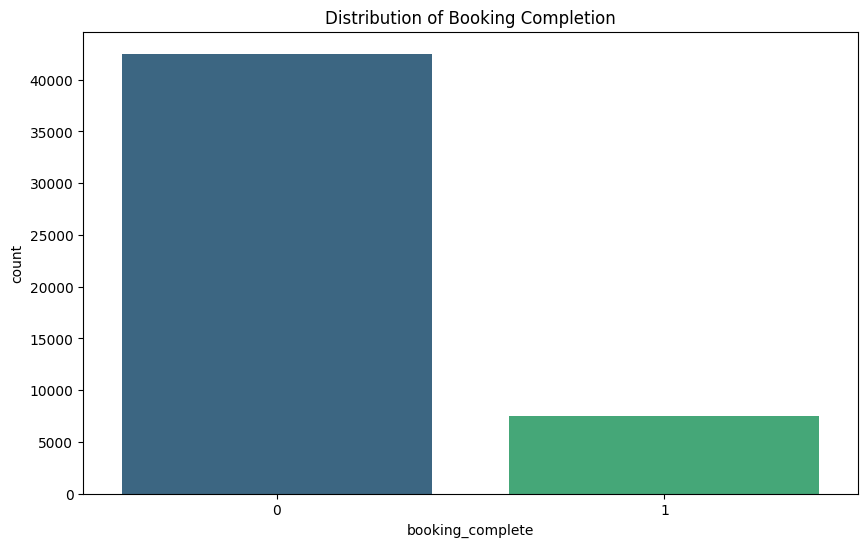

In [14]:
# Booking completion rate analysis
completion_rate = df['booking_complete'].mean() * 100
print(f"Overall booking completion rate: {completion_rate:.2f}%")

# Visualize booking completion distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='booking_complete', palette='viridis')
plt.title('Distribution of Booking Completion')
plt.savefig('Class Distribution1.png', bbox_inches='tight', dpi=300)
plt.show()

In [15]:
# %%  Handle Class Imbalance
print(f"Class distribution:\n{df['booking_complete'].value_counts(normalize=True)}")

Class distribution:
booking_complete
0    0.85044
1    0.14956
Name: proportion, dtype: float64


<ipython-input-16-1f741e233a0a>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='booking_complete', palette='viridis')


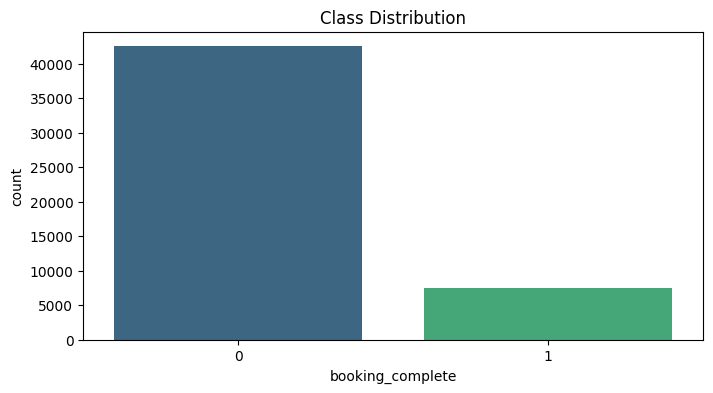

In [16]:
# Visualize class balance
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='booking_complete', palette='viridis')
plt.title('Class Distribution')
plt.savefig('Class Distribution.png', bbox_inches='tight', dpi=300)

plt.show()

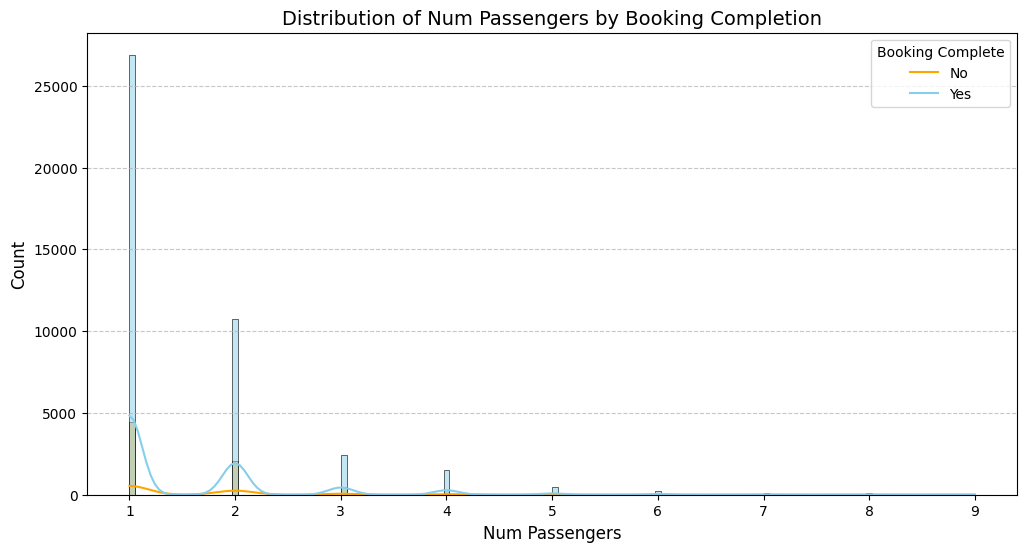

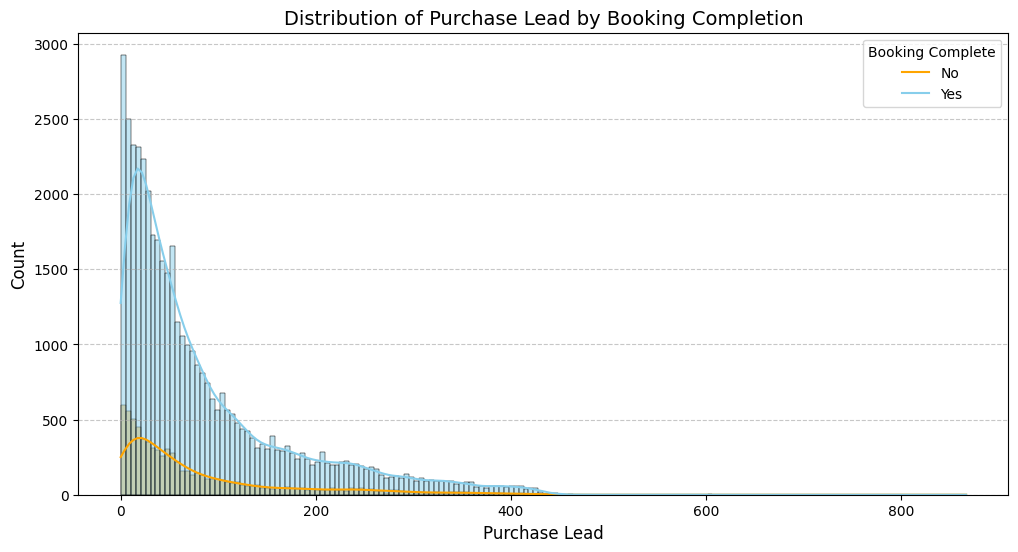

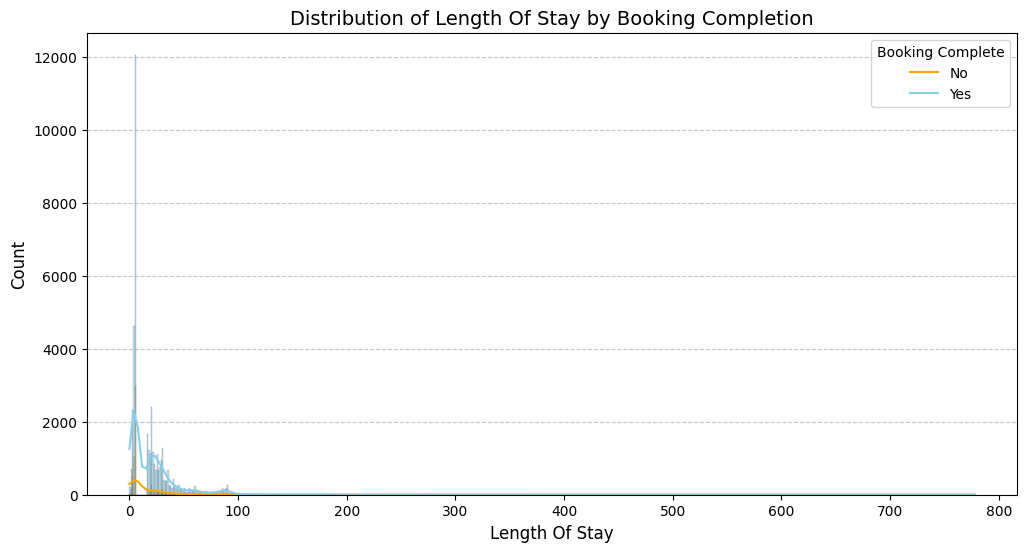

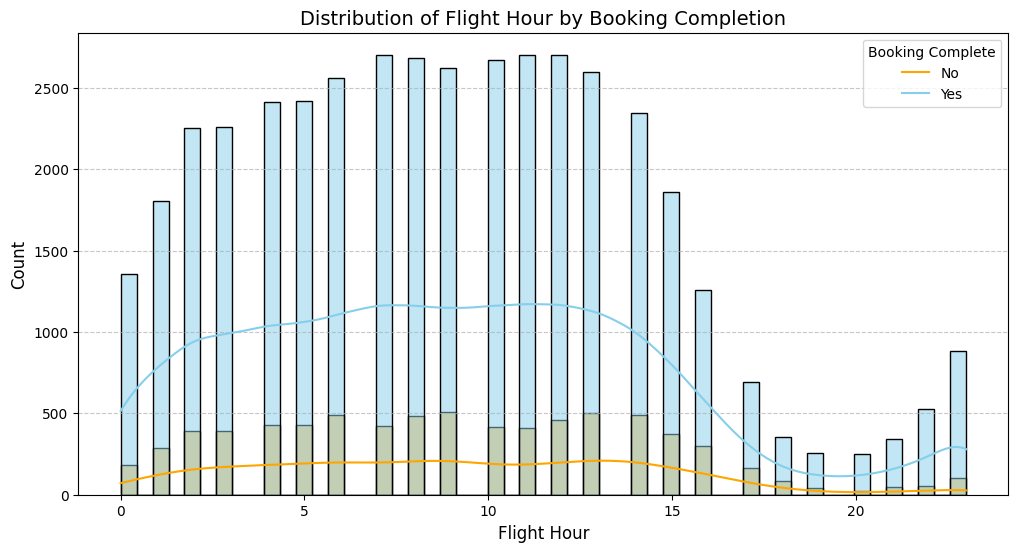

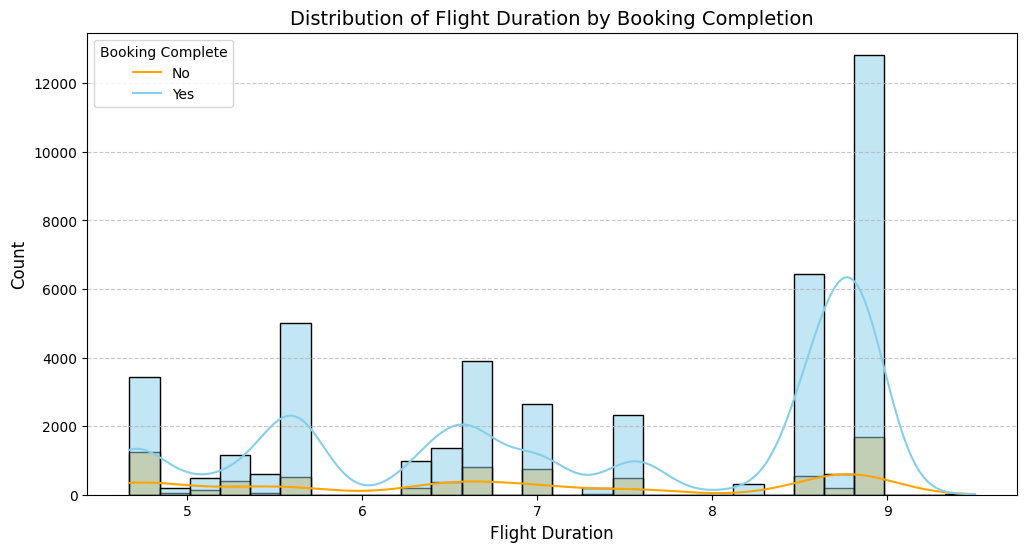

In [17]:
# Analyze numerical features distribution
numerical_cols = ['num_passengers', 'purchase_lead', 'length_of_stay',
                  'flight_hour', 'flight_duration']

# Define a color palette for better aesthetics
palette = {0: "skyblue", 1: "orange"}  # Use integers for the palette keys

for col in numerical_cols:
    # Create a standalone plot for each numerical feature
    plt.figure(figsize=(12, 6))

    # Distribution plot
    sns.histplot(
        data=df,
        x=col,
        hue='booking_complete',
        multiple="layer",  # Overlay histograms
        palette=palette,  # Use the defined color palette
        kde=True,  # Add a kernel density estimate (KDE) curve
    )
    plt.title(f'Distribution of {col.replace("_", " ").title()} by Booking Completion', fontsize=14)
    plt.xlabel(col.replace("_", " ").title(), fontsize=12)  # Format x-axis label
    plt.ylabel('Count', fontsize=12)  # Format y-axis label
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines for better readability
    plt.legend(title="Booking Complete", labels=["No", "Yes"])  # Add legend with clear labels

    # Save the plot as a standalone file
    clean_col_name = col.replace(" ", "_").replace("/", "_")  # Replace spaces and special characters
    plt.savefig(f"Distribution_of_{clean_col_name}.png", bbox_inches='tight', dpi=300)

    # Show the plot
    plt.show()

<ipython-input-18-5aa44a827e7d>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=completion_rates.index, y=completion_rates.values, palette="viridis")


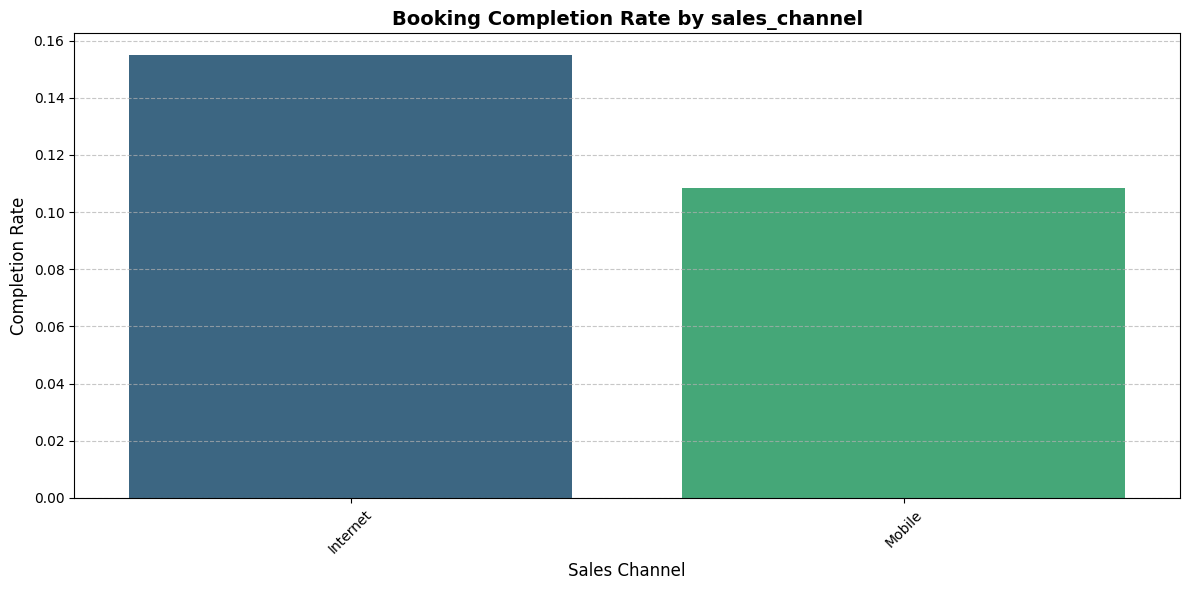


Value counts for sales_channel:
sales_channel
Internet    44382
Mobile       5618
Name: count, dtype: int64

Completion rates for sales_channel:
sales_channel
Internet    0.154770
Mobile      0.108402
Name: booking_complete, dtype: float64
--------------------------------------------------


<ipython-input-18-5aa44a827e7d>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=completion_rates.index, y=completion_rates.values, palette="viridis")


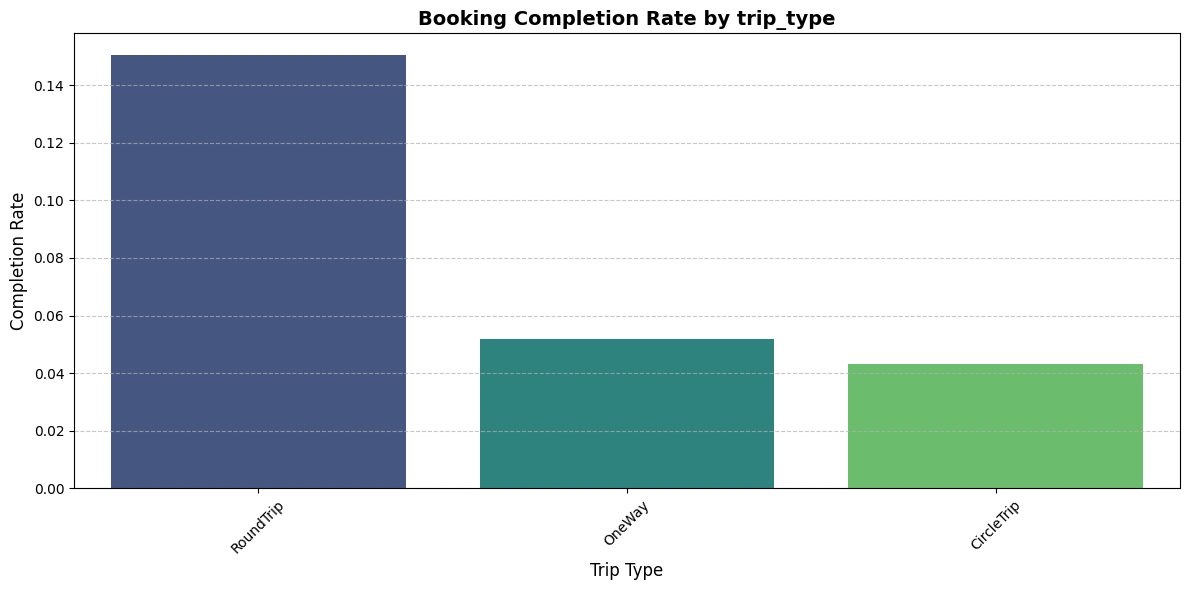


Value counts for trip_type:
trip_type
RoundTrip     49497
OneWay          387
CircleTrip      116
Name: count, dtype: int64

Completion rates for trip_type:
trip_type
RoundTrip     0.150575
OneWay        0.051680
CircleTrip    0.043103
Name: booking_complete, dtype: float64
--------------------------------------------------


<ipython-input-18-5aa44a827e7d>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=completion_rates.index, y=completion_rates.values, palette="viridis")


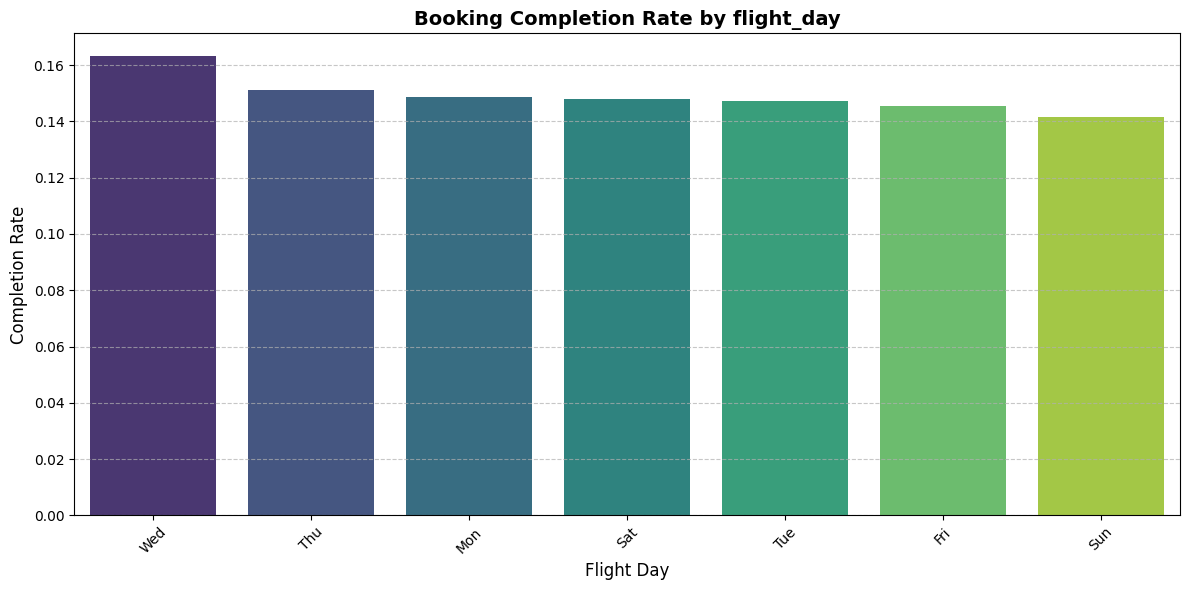


Value counts for flight_day:
flight_day
Mon    8102
Wed    7674
Tue    7673
Thu    7424
Fri    6761
Sun    6554
Sat    5812
Name: count, dtype: int64

Completion rates for flight_day:
flight_day
Wed    0.163148
Thu    0.151131
Mon    0.148605
Sat    0.148142
Tue    0.147139
Fri    0.145393
Sun    0.141440
Name: booking_complete, dtype: float64
--------------------------------------------------


<ipython-input-18-5aa44a827e7d>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=completion_rates.index, y=completion_rates.values, palette="viridis")


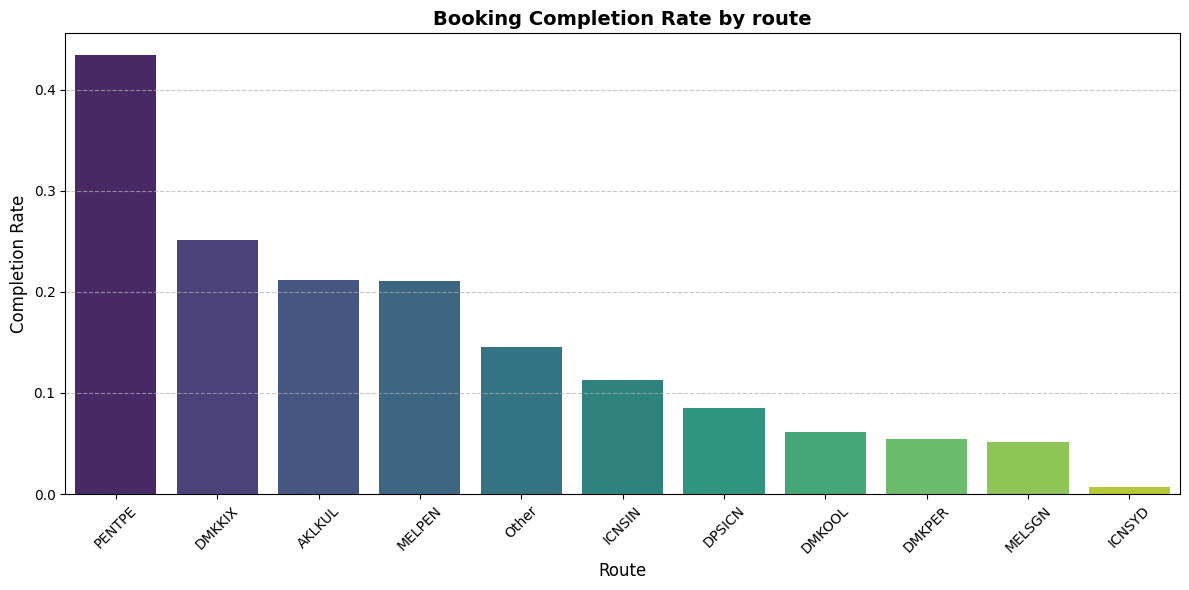


Value counts for route:
route
Other     40665
AKLKUL     2680
PENTPE      924
MELSGN      842
ICNSIN      801
DMKKIX      744
ICNSYD      695
DMKPER      679
DPSICN      666
DMKOOL      655
MELPEN      649
Name: count, dtype: int64

Completion rates for route:
route
PENTPE    0.433983
DMKKIX    0.251344
AKLKUL    0.211567
MELPEN    0.211094
Other     0.145432
ICNSIN    0.112360
DPSICN    0.085586
DMKOOL    0.061069
DMKPER    0.054492
MELSGN    0.051069
ICNSYD    0.007194
Name: booking_complete, dtype: float64
--------------------------------------------------


<ipython-input-18-5aa44a827e7d>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=completion_rates.index, y=completion_rates.values, palette="viridis")


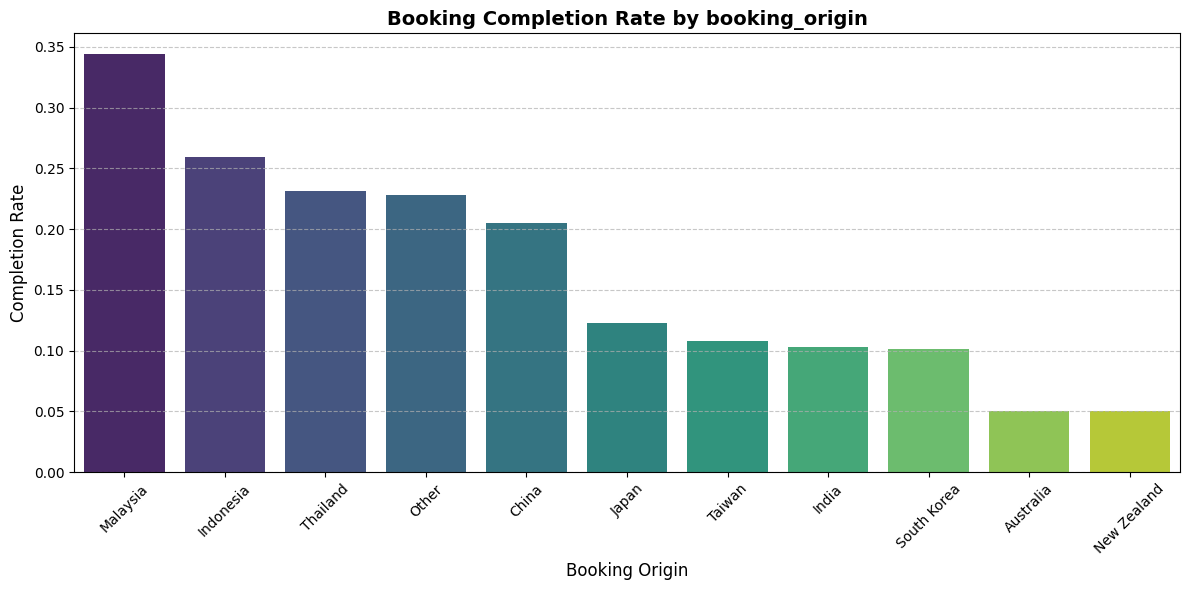


Value counts for booking_origin:
booking_origin
Australia      17872
Malaysia        7174
South Korea     4559
Other           4303
Japan           3885
China           3387
Indonesia       2369
Taiwan          2077
Thailand        2030
India           1270
New Zealand     1074
Name: count, dtype: int64

Completion rates for booking_origin:
booking_origin
Malaysia       0.344020
Indonesia      0.259603
Thailand       0.231527
Other          0.228213
China          0.204901
Japan          0.123037
Taiwan         0.107848
India          0.103150
South Korea    0.101338
Australia      0.050358
New Zealand    0.050279
Name: booking_complete, dtype: float64
--------------------------------------------------


In [18]:
# Analyze categorical features
categorical_cols = ['sales_channel', 'trip_type', 'flight_day', 'route', 'booking_origin']

# Function to limit categories and group others into "Other"
def group_categories(series, threshold=10):
    value_counts = series.value_counts()
    if len(value_counts) > threshold:
        top_categories = value_counts.head(threshold).index
        return series.apply(lambda x: x if x in top_categories else "Other")
    return series

# Create completion rate by categorical features
for col in categorical_cols:
    # Group categories if there are too many
    df_grouped = df.copy()
    df_grouped[col] = group_categories(df[col], threshold=10)  # Limit to top 10 categories

    # Calculate completion rates
    completion_rates = df_grouped.groupby(col)['booking_complete'].mean().sort_values(ascending=False)

    # Plot completion rates
    plt.figure(figsize=(12, 6))
    sns.barplot(x=completion_rates.index, y=completion_rates.values, palette="viridis")
    plt.title(f'Booking Completion Rate by {col}', fontsize=14, fontweight='bold')
    plt.xlabel(col.replace("_", " ").title(), fontsize=12)
    plt.ylabel('Completion Rate', fontsize=12)
    plt.xticks(rotation=45, fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines for better readability
    plt.tight_layout()

    # Save the plot with a clean filename
    clean_col_name = col.replace(" ", "_").replace("/", "_")  # Replace spaces and special characters
    plt.savefig(f'Booking_Completion_Rate_by_{clean_col_name}.png', bbox_inches='tight', dpi=300)

    # Show the plot
    plt.show()

    # Print value counts and completion rates
    print(f"\nValue counts for {col}:")
    print(df_grouped[col].value_counts())
    print(f"\nCompletion rates for {col}:")
    print(completion_rates)
    print("-" * 50)

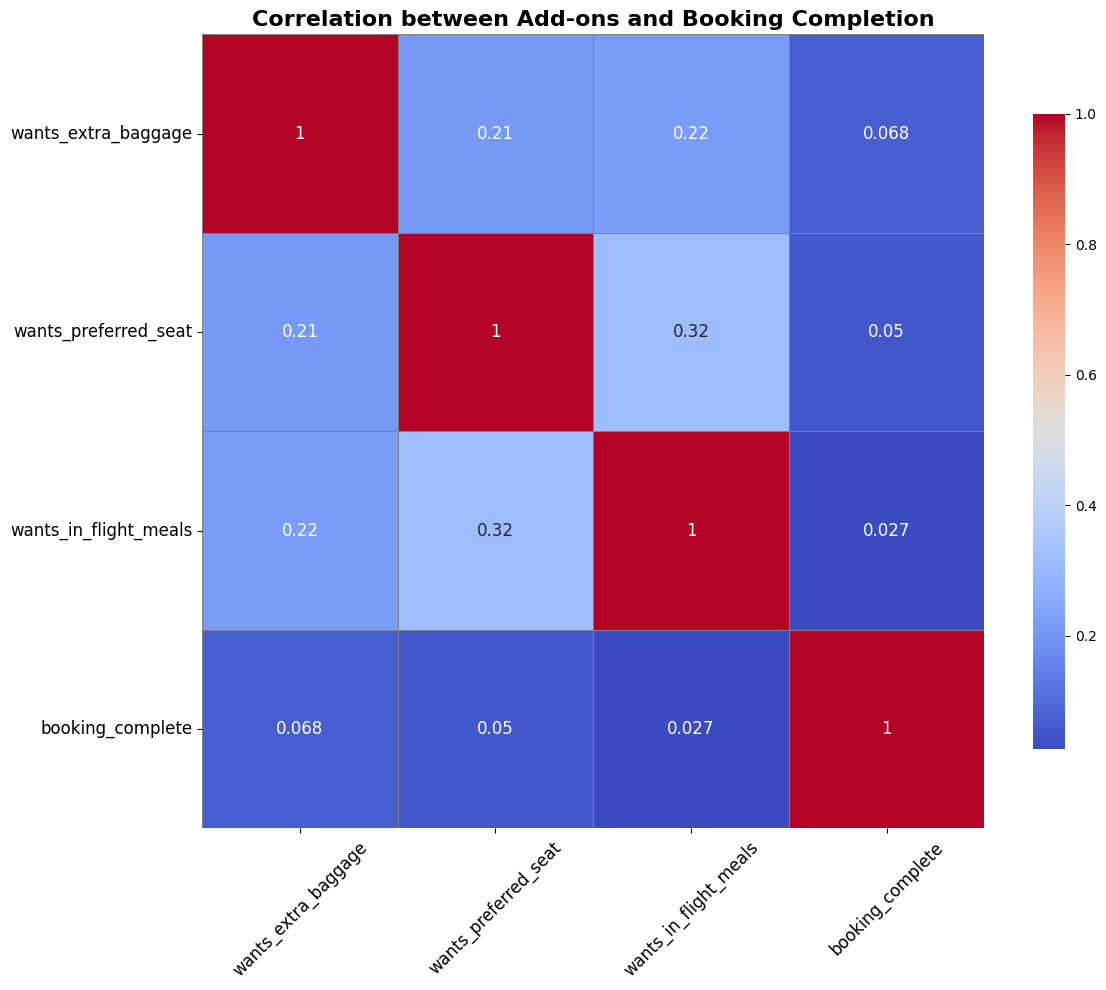

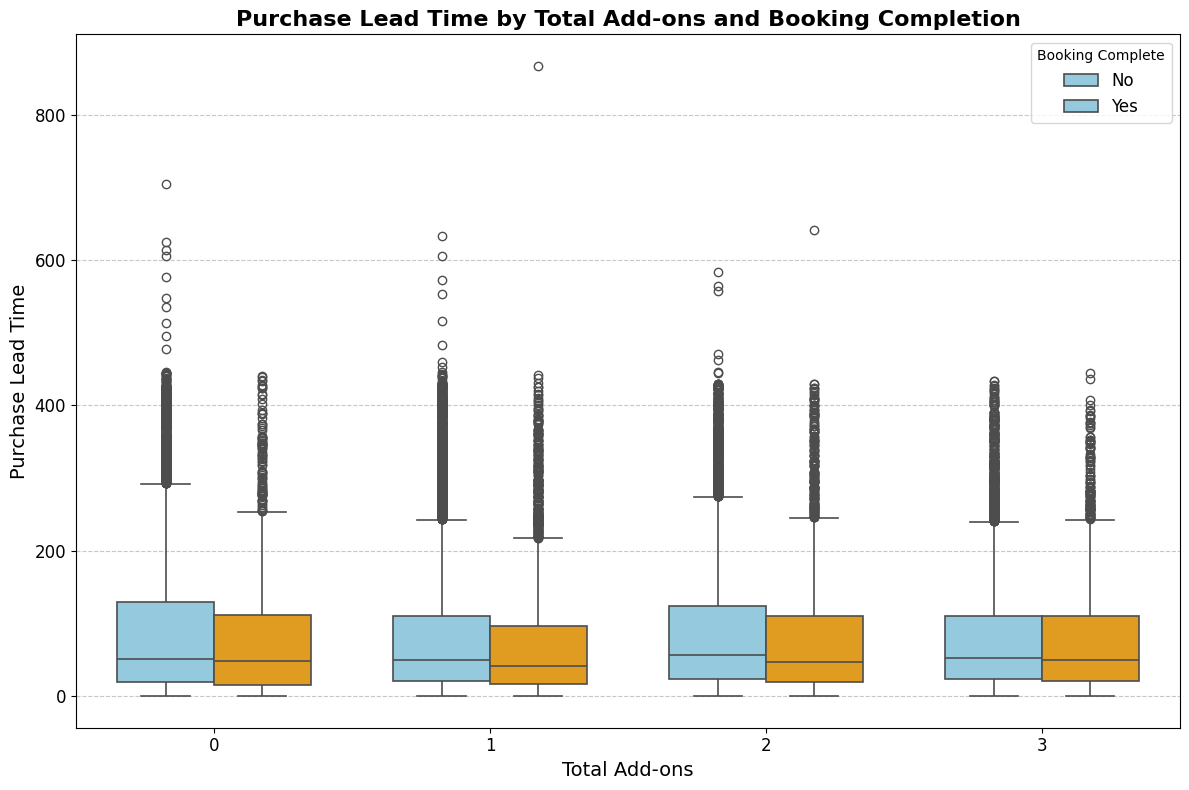

In [19]:
# Analyze add-on preferences
addon_cols = ['wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals']

# Create correlation matrix for add-ons
plt.figure(figsize=(12, 10))
correlation_matrix = df[addon_cols + ['booking_complete']].corr()

# Heatmap visualization
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    annot_kws={"fontsize": 12},  # Increase font size of annotations
    cbar_kws={"shrink": 0.8},   # Adjust color bar size
    linewidths=0.5,              # Add gridlines between cells
    linecolor='gray'             # Define gridline color
)
plt.title('Correlation between Add-ons and Booking Completion', fontsize=16, fontweight='bold')
plt.xticks(fontsize=12, rotation=45)  # Rotate x-axis labels for better readability
plt.yticks(fontsize=12, rotation=0)   # Adjust y-axis label size
plt.tight_layout()
plt.savefig("correlation_heatmap.png", bbox_inches='tight', dpi=300)  # Save the plot
plt.show()

# Analyze combined add-on effect
df['total_addons'] = df[addon_cols].sum(axis=1)

# Boxplot visualization
plt.figure(figsize=(12, 8))
sns.boxplot(
    data=df,
    x='total_addons',
    y='purchase_lead',
    hue='booking_complete',
    palette={0: "skyblue", 1: "orange"},  # Use a custom color palette
    linewidth=1.2,                       # Adjust boxplot line thickness
    width=0.7                            # Adjust boxplot width
)
plt.title('Purchase Lead Time by Total Add-ons and Booking Completion', fontsize=16, fontweight='bold')
plt.xlabel('Total Add-ons', fontsize=14)  # Format x-axis label
plt.ylabel('Purchase Lead Time', fontsize=14)  # Format y-axis label
plt.xticks(fontsize=12)  # Adjust x-axis tick font size
plt.yticks(fontsize=12)  # Adjust y-axis tick font size
plt.legend(title="Booking Complete", labels=["No", "Yes"], fontsize=12)  # Customize legend
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines for better readability
plt.tight_layout()
plt.savefig("purchase_lead_by_addons.png", bbox_inches='tight', dpi=300)  # Save the plot
plt.show()

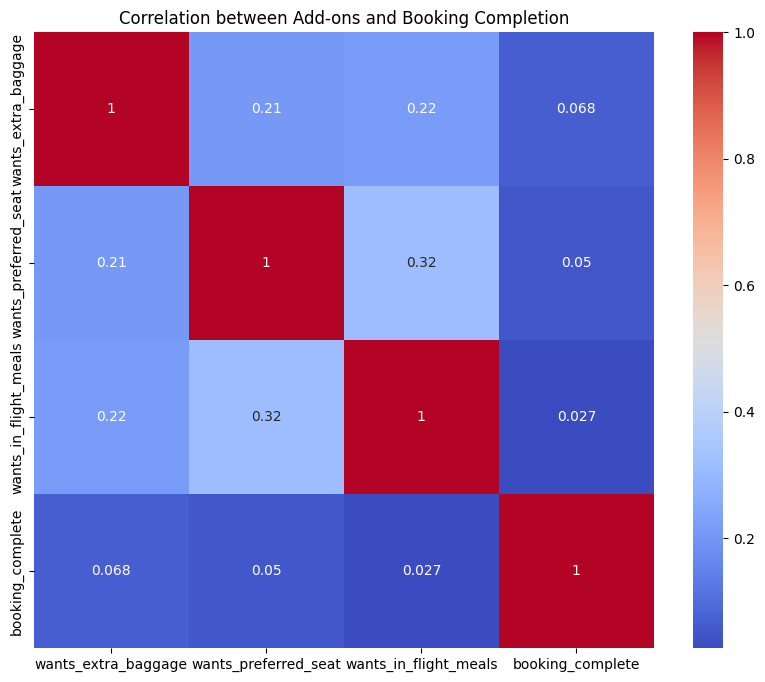

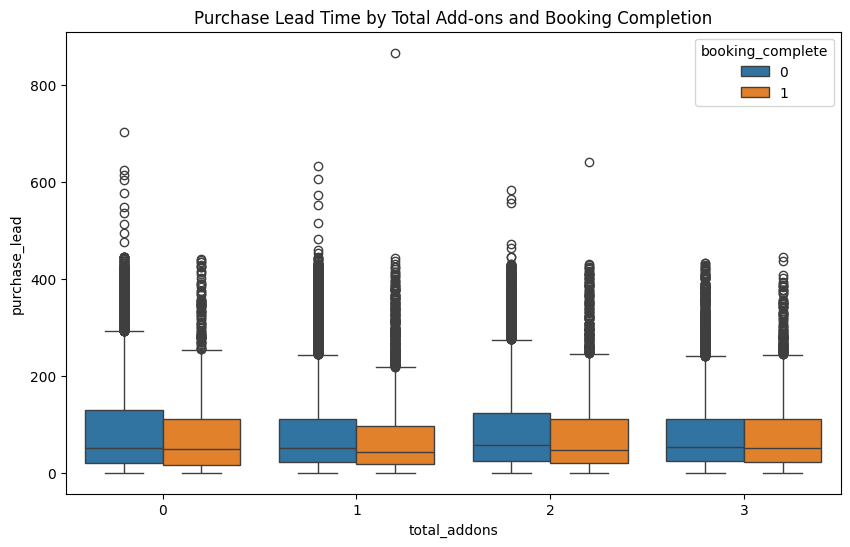

In [20]:
# Analyze add-on preferences
addon_cols = ['wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals']

# Create correlation matrix for add-ons
plt.figure(figsize=(10, 8))
sns.heatmap(df[addon_cols + ['booking_complete']].corr(),
            annot=True, cmap='coolwarm')
plt.title('Correlation between Add-ons and Booking Completion')
plt.show()

# Analyze combined add-on effect
df['total_addons'] = df[addon_cols].sum(axis=1)
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='total_addons', y='purchase_lead', hue='booking_complete')
plt.title('Purchase Lead Time by Total Add-ons and Booking Completion')
plt.show()

<ipython-input-21-0ba474db9bdc>:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
<ipython-input-21-0ba474db9bdc>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


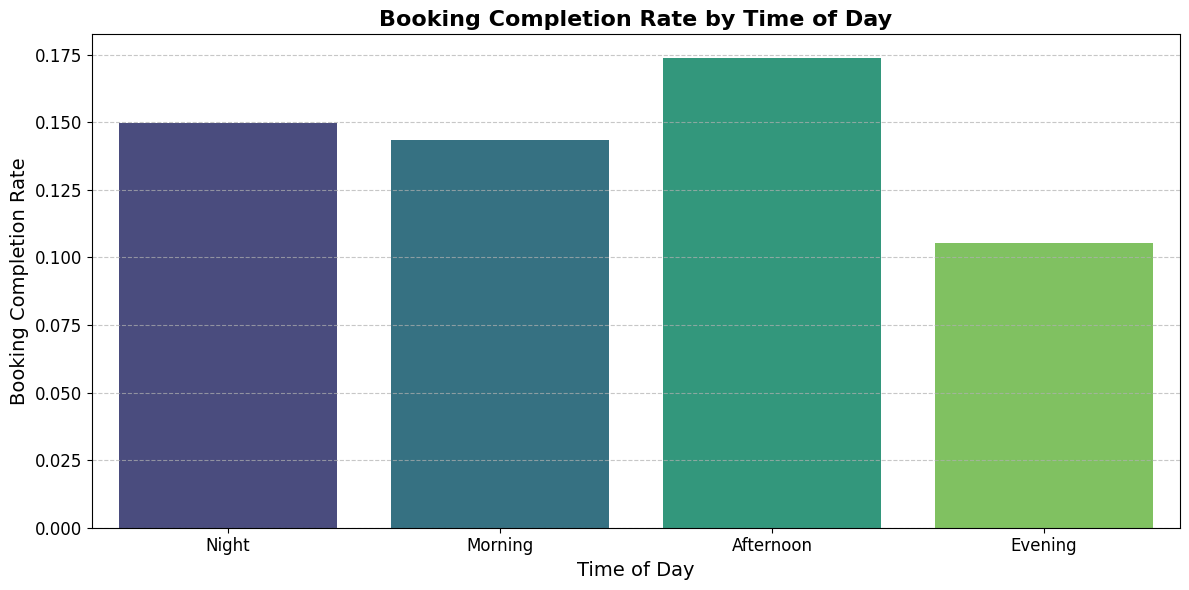

<ipython-input-21-0ba474db9bdc>:30: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
<ipython-input-21-0ba474db9bdc>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


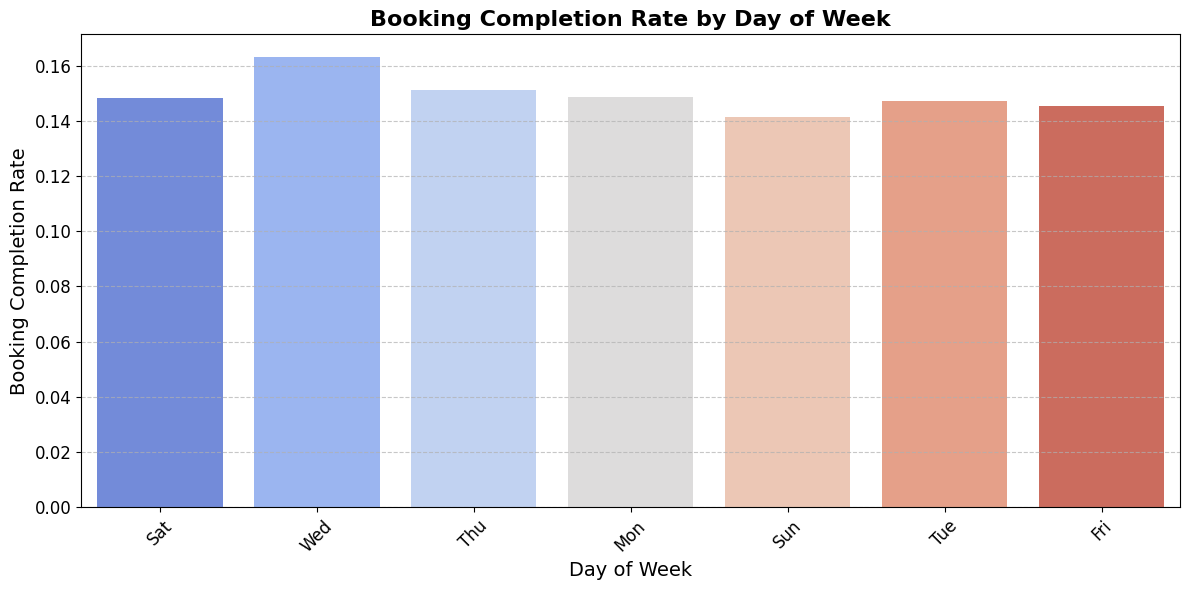

In [21]:
# Time-based analysis
# Create hour groups
df['hour_group'] = pd.cut(
    df['flight_hour'],
    bins=[0, 6, 12, 18, 24],
    labels=['Night', 'Morning', 'Afternoon', 'Evening']
)

# Analyze booking patterns by time
plt.figure(figsize=(12, 6))
sns.barplot(
    data=df,
    x='hour_group',
    y='booking_complete',
    palette='viridis',  # Use a gradient color palette
    ci=None  # Remove confidence intervals for cleaner visualization
)
plt.title('Booking Completion Rate by Time of Day', fontsize=16, fontweight='bold')
plt.xlabel('Time of Day', fontsize=14)
plt.ylabel('Booking Completion Rate', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines for better readability
plt.tight_layout()
plt.savefig("booking_completion_by_time_of_day.png", bbox_inches='tight', dpi=300)  # Save the plot
plt.show()

# Analyze day of week patterns
plt.figure(figsize=(12, 6))
sns.barplot(
    data=df,
    x='flight_day',
    y='booking_complete',
    palette='coolwarm',  # Use a different color palette
    ci=None  # Remove confidence intervals for cleaner visualization
)
plt.title('Booking Completion Rate by Day of Week', fontsize=16, fontweight='bold')
plt.xlabel('Day of Week', fontsize=14)
plt.ylabel('Booking Completion Rate', fontsize=14)
plt.xticks(fontsize=12, rotation=45)  # Rotate x-axis labels for better readability
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines for better readability
plt.tight_layout()
plt.savefig("booking_completion_by_day_of_week.png", bbox_inches='tight', dpi=300)  # Save the plot
plt.show()

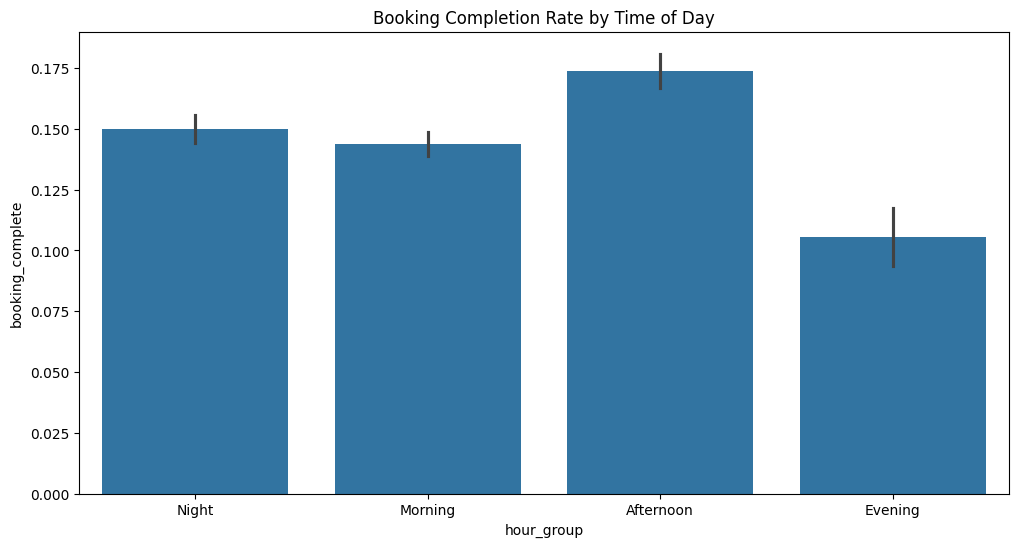

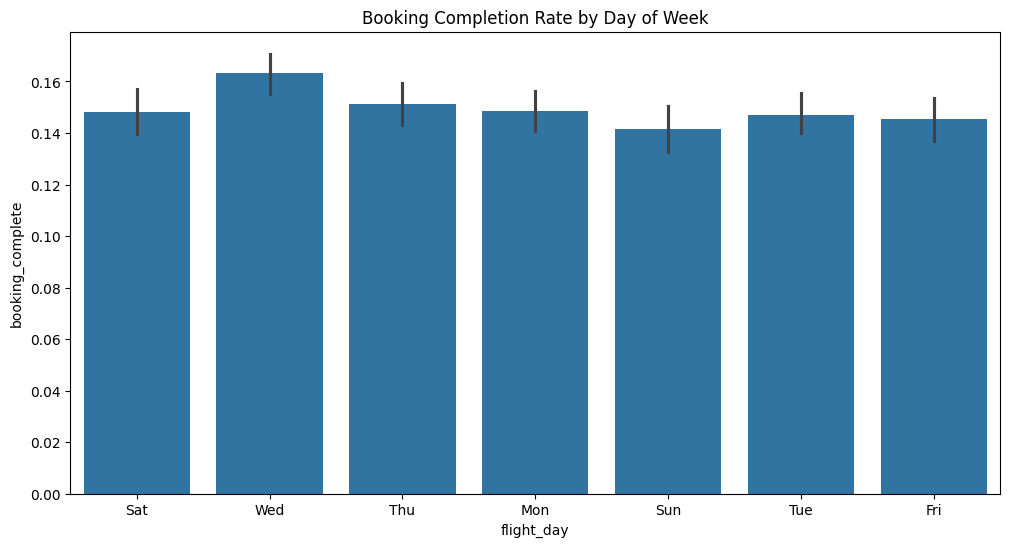

In [22]:
# Time-based analysis
# Create hour groups
df['hour_group'] = pd.cut(df['flight_hour'],
                         bins=[0, 6, 12, 18, 24],
                         labels=['Night', 'Morning', 'Afternoon', 'Evening'])

# Analyze booking patterns by time
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='hour_group', y='booking_complete')
plt.title('Booking Completion Rate by Time of Day')
plt.show()

# Analyze day of week patterns
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='flight_day', y='booking_complete')
plt.title('Booking Completion Rate by Day of Week')
plt.show()

In [23]:
# Feature Engineering

In [24]:
# Create a copy to avoid modifying the original dataframe
df_processed = df.copy()

In [25]:
# Convert flight_day to numeric
day_mapping = {"Mon": 1, "Tue": 2, "Wed": 3, "Thu": 4, "Fri": 5, "Sat": 6, "Sun": 7}
df_processed['flight_day'] = df_processed['flight_day'].map(day_mapping)

In [26]:
# Create new features
df_processed['is_weekend'] = df_processed['flight_day'].isin([6, 7]).astype(int)
df_processed['is_business_hours'] = ((df_processed['flight_hour'] >= 8) & (df_processed['flight_hour'] <= 18)).astype(int)
df_processed['total_add_ons'] = df_processed[['wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals']].sum(axis=1)
df_processed['trip_complexity'] = df_processed['length_of_stay'] * df_processed['num_passengers']
df_processed['lead_time_category'] = pd.cut(df_processed['purchase_lead'], bins=[0, 7, 30, 90, np.inf], labels=['last_minute', 'short_term', 'medium_term', 'long_term'])
df_processed['stay_duration_category'] = pd.cut(df_processed['length_of_stay'], bins=[0, 3, 7, 14, np.inf], labels=['short', 'week', 'fortnight', 'extended'])


In [27]:
# Encode categorical variables
categorical_columns = ['sales_channel', 'trip_type', 'route', 'booking_origin', 'hour_group', 'lead_time_category', 'stay_duration_category']
for col in categorical_columns:
    le = LabelEncoder()
    df_processed[col] = le.fit_transform(df_processed[col].astype(str))

In [28]:
# Separate features and target
X = df_processed.drop('booking_complete', axis=1)
y = df_processed['booking_complete']


In [29]:
df_processed.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,...,flight_duration,booking_complete,total_addons,hour_group,is_weekend,is_business_hours,total_add_ons,trip_complexity,lead_time_category,stay_duration_category
0,2,0,2,262,19,7,6,0,61,1,...,5.52,0,1,2,1,0,1,38,1,0
1,1,0,2,112,20,3,6,0,61,0,...,5.52,0,0,3,1,0,0,20,1,0
2,2,0,2,243,22,17,3,0,36,1,...,5.52,0,2,0,0,1,2,44,1,0
3,1,0,2,96,31,4,6,0,61,0,...,5.52,0,1,3,1,0,1,31,1,0
4,2,0,2,68,22,15,3,0,36,1,...,5.52,0,2,0,0,1,2,44,2,0


In [30]:
# Model Training and Evaluation

In [31]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [32]:
# Scale numerical features before applying SMOTE
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [33]:
# Handle Class Imbalance (SMOTE)
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

In [34]:
# Model Training with Hyperparameter Tuning
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': [None] + list(np.arange(5, 30, 5)),
    'class_weight': ['balanced', 'balanced_subsample']
}

In [35]:
rf = RandomForestClassifier(random_state=42)
search = RandomizedSearchCV(rf, param_dist, n_iter=20, cv=3, scoring='roc_auc', n_jobs=-1)
search.fit(X_train_res, y_train_res)
best_model = search.best_estimator_

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [36]:
# Cross-validation evaluation
cv_scores = cross_val_score(best_model, X_train_res, y_train_res, cv=5, scoring='roc_auc')
print(f"Mean CV ROC-AUC: {cv_scores.mean():.3f} (±{cv_scores.std():.3f})")

Mean CV ROC-AUC: 0.974 (±0.048)


In [37]:
# Final predictions and evaluation
y_pred = best_model.predict(X_test_scaled)
y_proba = best_model.predict_proba(X_test_scaled)[:, 1]

In [38]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.96      0.91      8504
           1       0.39      0.15      0.22      1496

    accuracy                           0.84     10000
   macro avg       0.63      0.56      0.56     10000
weighted avg       0.79      0.84      0.81     10000



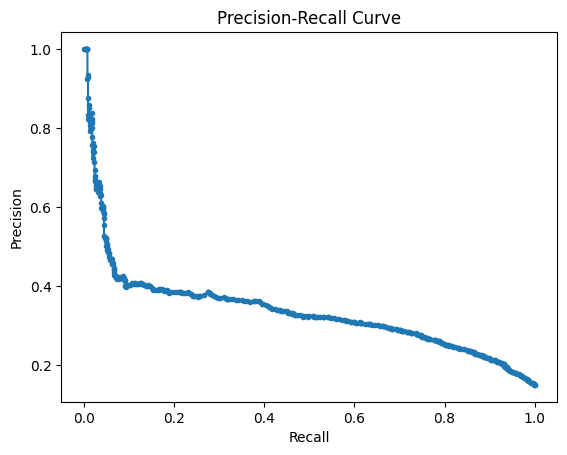

In [39]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.figure()
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


<ipython-input-40-e315b439fc0a>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


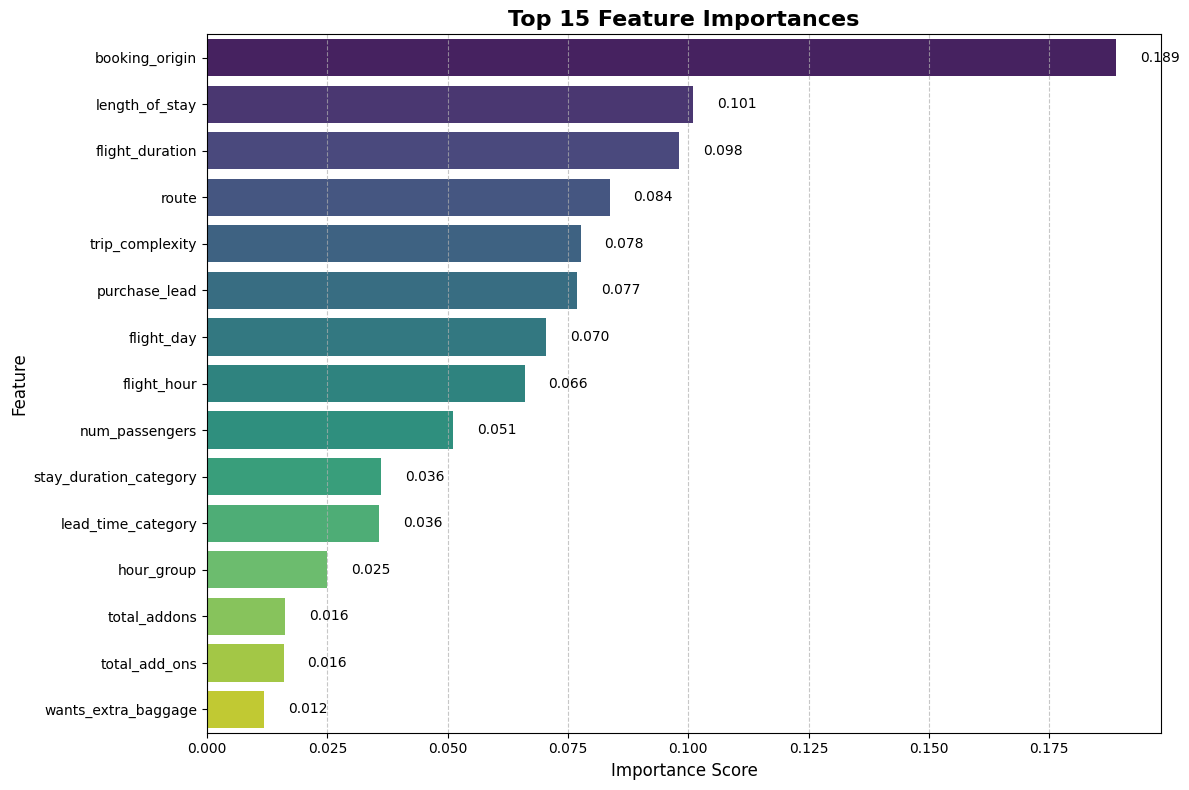

In [40]:
# Feature Importance Visualization
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)  # Use 'ascending=False' instead of 'descending=True'

# Create a color palette for better aesthetics
colors = sns.color_palette("viridis", len(feature_importance.head(15)))  # Use a gradient color palette

# Plot top 15 features
plt.figure(figsize=(12, 8))
barplot = sns.barplot(
    x='importance',
    y='feature',
    data=feature_importance.head(15),
    palette=colors  # Apply the color palette
)

# Add annotations for each bar
for index, value in enumerate(feature_importance['importance'].head(15)):
    barplot.text(value + 0.005, index, f"{value:.3f}", color='black', va="center", fontsize=10)

# Customize the plot
plt.title('Top 15 Feature Importances', fontsize=16, fontweight='bold')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)  # Add gridlines for better readability
plt.tight_layout()

# Show the plot
plt.show()

In [41]:
# SHAP Visualization
top_features = feature_importance.head(5)['feature'].tolist()
feature_indices = [X.columns.get_loc(f) for f in top_features]


In [42]:
# Create subset data
X_train_top = X_train_res[:, feature_indices]
X_test_top = X_test_scaled[:, feature_indices]

In [43]:
# Retrain model on top features
model_top = RandomForestClassifier(**best_model.get_params())
model_top.fit(X_train_top, y_train_res)

RandomForestClassifier(class_weight='balanced_subsample', n_estimators=416,
                       random_state=42)

In [44]:
# SHAP explainer
sample_size = 1000
sample_indices = np.random.choice(X_test_top.shape[0], sample_size, replace=False)
X_sample = X_test_top[sample_indices]

In [45]:
explainer = shap.TreeExplainer(model_top)
shap_values = explainer.shap_values(X_sample)

SHAP values structure: (1000, 5, 2)
SHAP values for class 1 shape: (1000, 5)


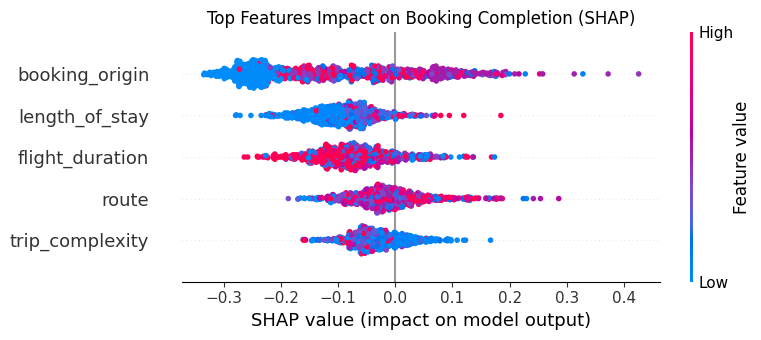

In [46]:
# Debug SHAP values shape
explainer = shap.Explainer(model_top)  # Use shap.Explainer instead of shap.TreeExplainer
shap_values = explainer(X_sample)

# Print SHAP values structure
print("SHAP values structure:", shap_values.values.shape)

# Extract SHAP values for the positive class (class 1)
shap_values_class_1 = shap_values.values[:, :, 1]  # SHAP values for class 1
print(f"SHAP values for class 1 shape: {shap_values_class_1.shape}")

# Summary plot
plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_values_class_1,  # Use SHAP values for class 1
    X_sample,
    feature_names=top_features,
    plot_type='dot',
    show=False
)
plt.title("Top Features Impact on Booking Completion (SHAP)")
plt.tight_layout()
plt.savefig("shap_summary_plot.png", bbox_inches='tight', dpi=300)
plt.show()

<Figure size 1000x600 with 0 Axes>

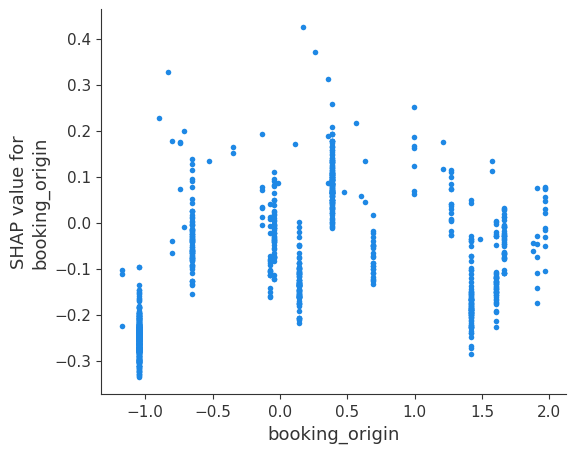

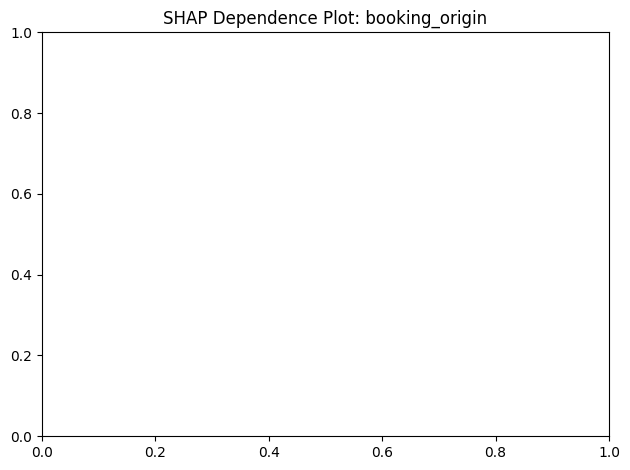

<Figure size 1000x600 with 0 Axes>

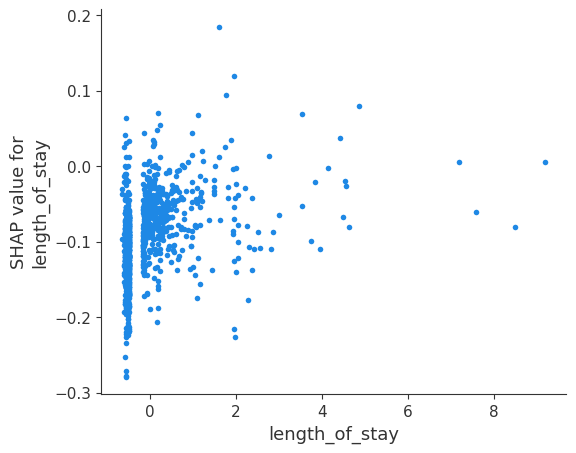

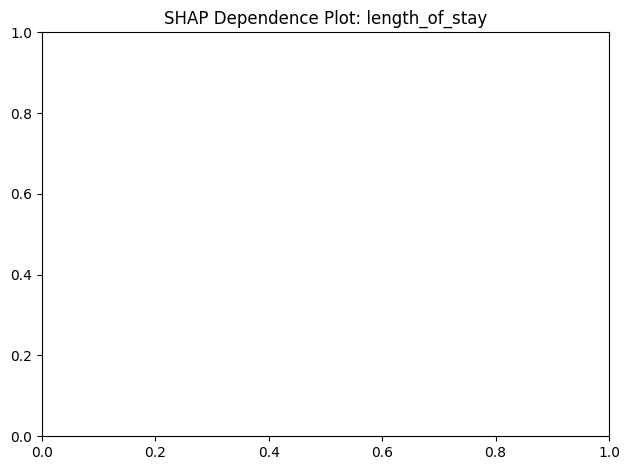

<Figure size 1000x600 with 0 Axes>

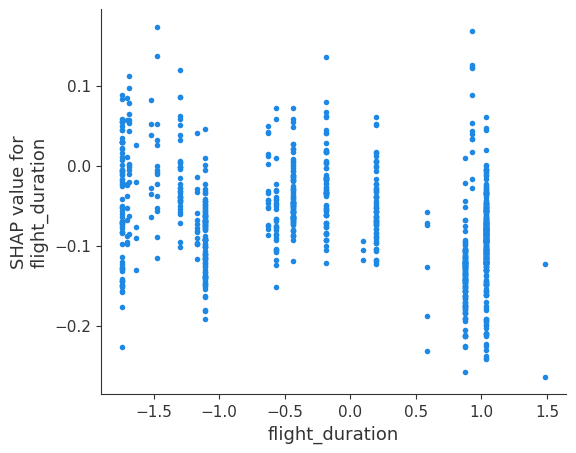

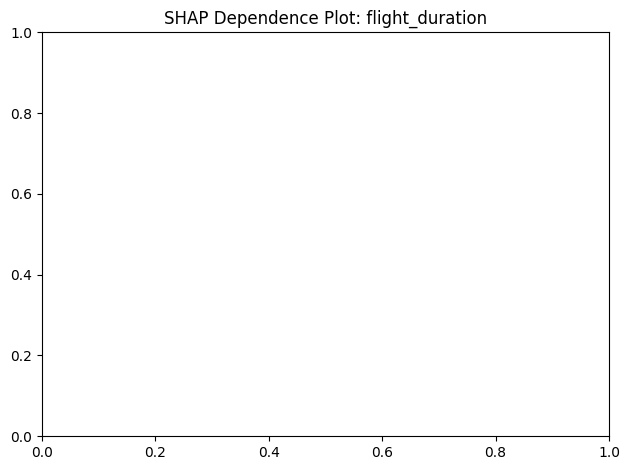

<Figure size 1000x600 with 0 Axes>

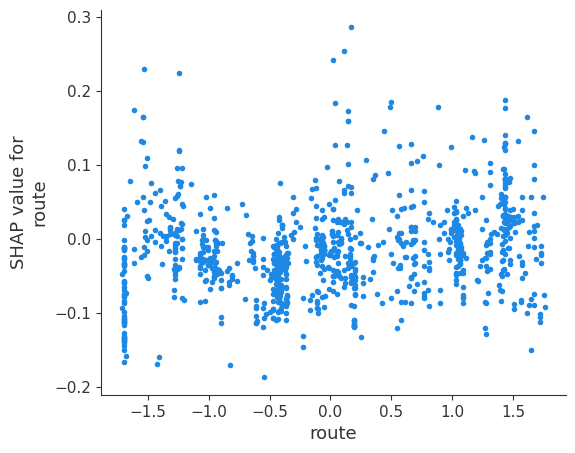

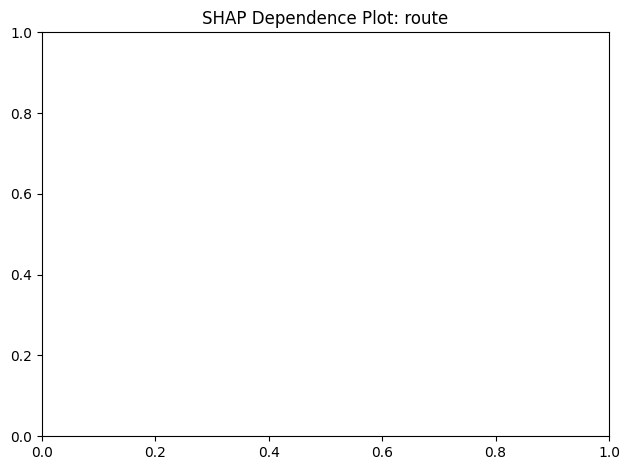

<Figure size 1000x600 with 0 Axes>

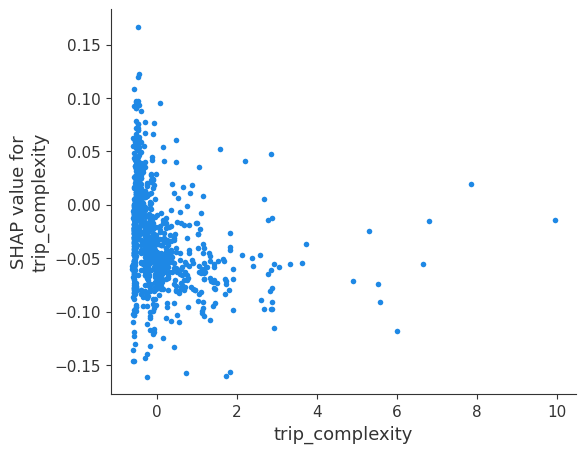

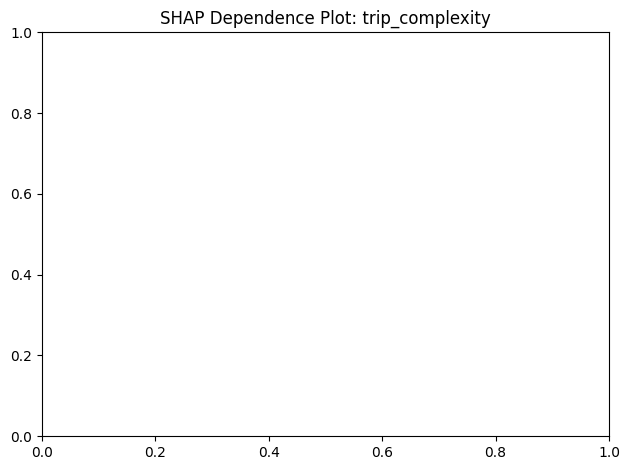

In [47]:
# Dependence plots for top features
for idx, feature in enumerate(top_features):
    plt.figure(figsize=(10, 6))
    shap.dependence_plot(
        idx,  # Feature index
        shap_values_class_1,  # SHAP values for class 1
        X_sample,
        feature_names=top_features,
        interaction_index=None  # No interaction effect
    )
    plt.title(f'SHAP Dependence Plot: {feature}')
    plt.tight_layout()
    # Save the plot as a high-resolution image
    clean_feature_name = feature.replace(" ", "_").replace("/", "_")  # Replace spaces and special characters
    plt.savefig(f"shap_dependence_plot_{clean_feature_name}.png", bbox_inches='tight', dpi=300)
    plt.show()